# <div style="padding: 30px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#37644A;overflow:hidden;background-color:#37644A"><b></b> <b>Achtergrond</b></div>



The CalCOFI data set represents the longest (1949-present) and most complete (more than 50,000 sampling stations) time series of oceanographic and larval fish data in the world. It includes abundance data on the larvae of over 250 species of fish; larval length frequency data and egg abundance data on key commercial species; and oceanographic and plankton data. The physical, chemical, and biological data collected at regular time and space intervals quickly became valuable for documenting climatic cycles in the California Current and a range of biological responses to them. CalCOFI research drew world attention to the biological response to the dramatic Pacific-warming event in 1957-58 and introduced the term “El Niño” into the scientific literature.

CalCOFI conducts quarterly cruises off southern & central California, collecting a suite of hydrographic and biological data on station and underway. Data collected at depths down to 500 m include: temperature, salinity, oxygen, phosphate, silicate, nitrate and nitrite, chlorophyll, transmissometer, PAR, C14 primary productivity, phytoplankton biodiversity, zooplankton biomass, and zooplankton biodiversity.

### <b><span style='color:#F1A424'> </span> Doel</b>

We doen alsof de temperatuur voor een aantal rijen niet gemeten is en het doel is dus om de temperatuur te voorspellen. 


# <div style="padding: 30px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#37644A;overflow:hidden;background-color:#37644A"><b></b> <b>Data inlezen en packages installeren</b></div>



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import seaborn as sns
import plotly.express as px
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
import plotly.express as px
import plotly.graph_objects as go
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import chardet

In [2]:
# Detect file encoding
with open('data/194903-202105_Bottle.csv', 'rb') as f:
    result = chardet.detect(f.read(100000)) 
    detected_encoding = result['encoding']

print("Detected Encoding:", detected_encoding)

# Now load CSV using the detected encoding
df = pd.read_csv('data/194903-202105_Bottle.csv', encoding=detected_encoding)
cast = pd.read_csv('data/194903-202105_Cast.csv')

Detected Encoding: ISO-8859-1


C:\Users\f_voe\AppData\Local\Temp\ipykernel_1792\2582622259.py:9: DtypeWarning: Columns (47,61) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/194903-202105_Bottle.csv', encoding=detected_encoding)
C:\Users\f_voe\AppData\Local\Temp\ipykernel_1792\2582622259.py:10: DtypeWarning: Columns (40,41,44,45,46,47) have mixed types. Specify dtype option on import or set low_memory=False.
  cast = pd.read_csv('data/194903-202105_Cast.csv')


In [49]:
df.shape, cast.shape

((895371, 62), (35644, 61))

In [3]:
#bot=pd.read_csv('/kaggle/input/calcofi/bottle.csv',low_memory=False)#.to_csv('bottlecsv.csv')
#cast=pd.read_csv('/kaggle/input/calcofi/cast.csv',low_memory=False)#.to_csv('castcsv.csv')

# <div style="padding: 30px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#37644A;overflow:hidden;background-color:#37644A"><b>Dataverkenning en Preprocessing</b></div>



### <b><span style='color:#F1A424'> </span> Kolomselectie</b>
De meeste kolommen zijn niet relevant voor het bepalen van de temperatuur. Ik weet niet of de dichtheid wordt gemeten of berekend, maar deze is direct gerelateerd aan de temperatuur en zoutconcentratie, dus die haal ik er ook uit. Kolommen geselecteerd: Diepte, temperatuur, zoutconcentratie en zuurstofconcentratie. De Cst_Cnt kolom is om de connectie met de cast-tabel te maken.

In [4]:
bottle=df.iloc[:,[0,4,5,6,7]].copy()
bottle.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 895371 entries, 0 to 895370
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   Cst_Cnt  895371 non-null  int64  
 1   Depthm   895371 non-null  int64  
 2   T_degC   884402 non-null  float64
 3   Salnty   848015 non-null  float64
 4   O2ml_L   725630 non-null  float64
dtypes: float64(3), int64(2)
memory usage: 34.2 MB


In [5]:
cast_sel = cast[['Cst_Cnt', 'Cruise_ID', 'Julian_Date', 'Lat_Dec', 'Lon_Dec']].copy()
df_merge=bottle.merge(cast_sel, how='inner',on='Cst_Cnt')
df_merge.columns

Index(['Cst_Cnt', 'Depthm', 'T_degC', 'Salnty', 'O2ml_L', 'Cruise_ID',
       'Julian_Date', 'Lat_Dec', 'Lon_Dec'],
      dtype='object')

### <b><span style='color:#F1A424'> </span> Nan values verwijderen</b>


In [6]:
cols=df_merge.columns
for column in cols:
    df_merge=df_merge[~df_merge[column].isnull()]
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
Index: 690914 entries, 2160 to 895370
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Cst_Cnt      690914 non-null  int64  
 1   Depthm       690914 non-null  int64  
 2   T_degC       690914 non-null  float64
 3   Salnty       690914 non-null  float64
 4   O2ml_L       690914 non-null  float64
 5   Cruise_ID    690914 non-null  object 
 6   Julian_Date  690914 non-null  int64  
 7   Lat_Dec      690914 non-null  float64
 8   Lon_Dec      690914 non-null  float64
dtypes: float64(5), int64(3), object(1)
memory usage: 52.7+ MB


### <b><span style='color:#F1A424'> </span>Plots maken om data te verkennen</b>


Correlatiematrix

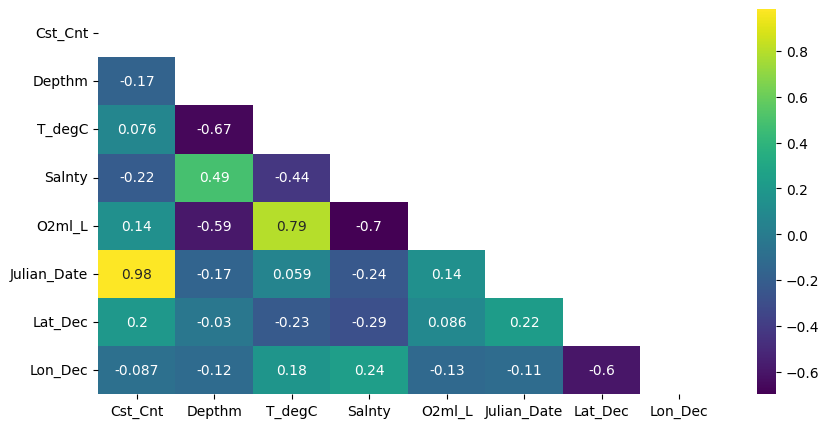

In [7]:
plt.figure(figsize=(10,5))
mask = np.triu(np.ones_like(df_merge.corr(numeric_only = True), dtype=bool))
sns.heatmap(df_merge.corr(numeric_only = True), cbar = True, annot = True, cmap="viridis", mask = mask);

Pairplot

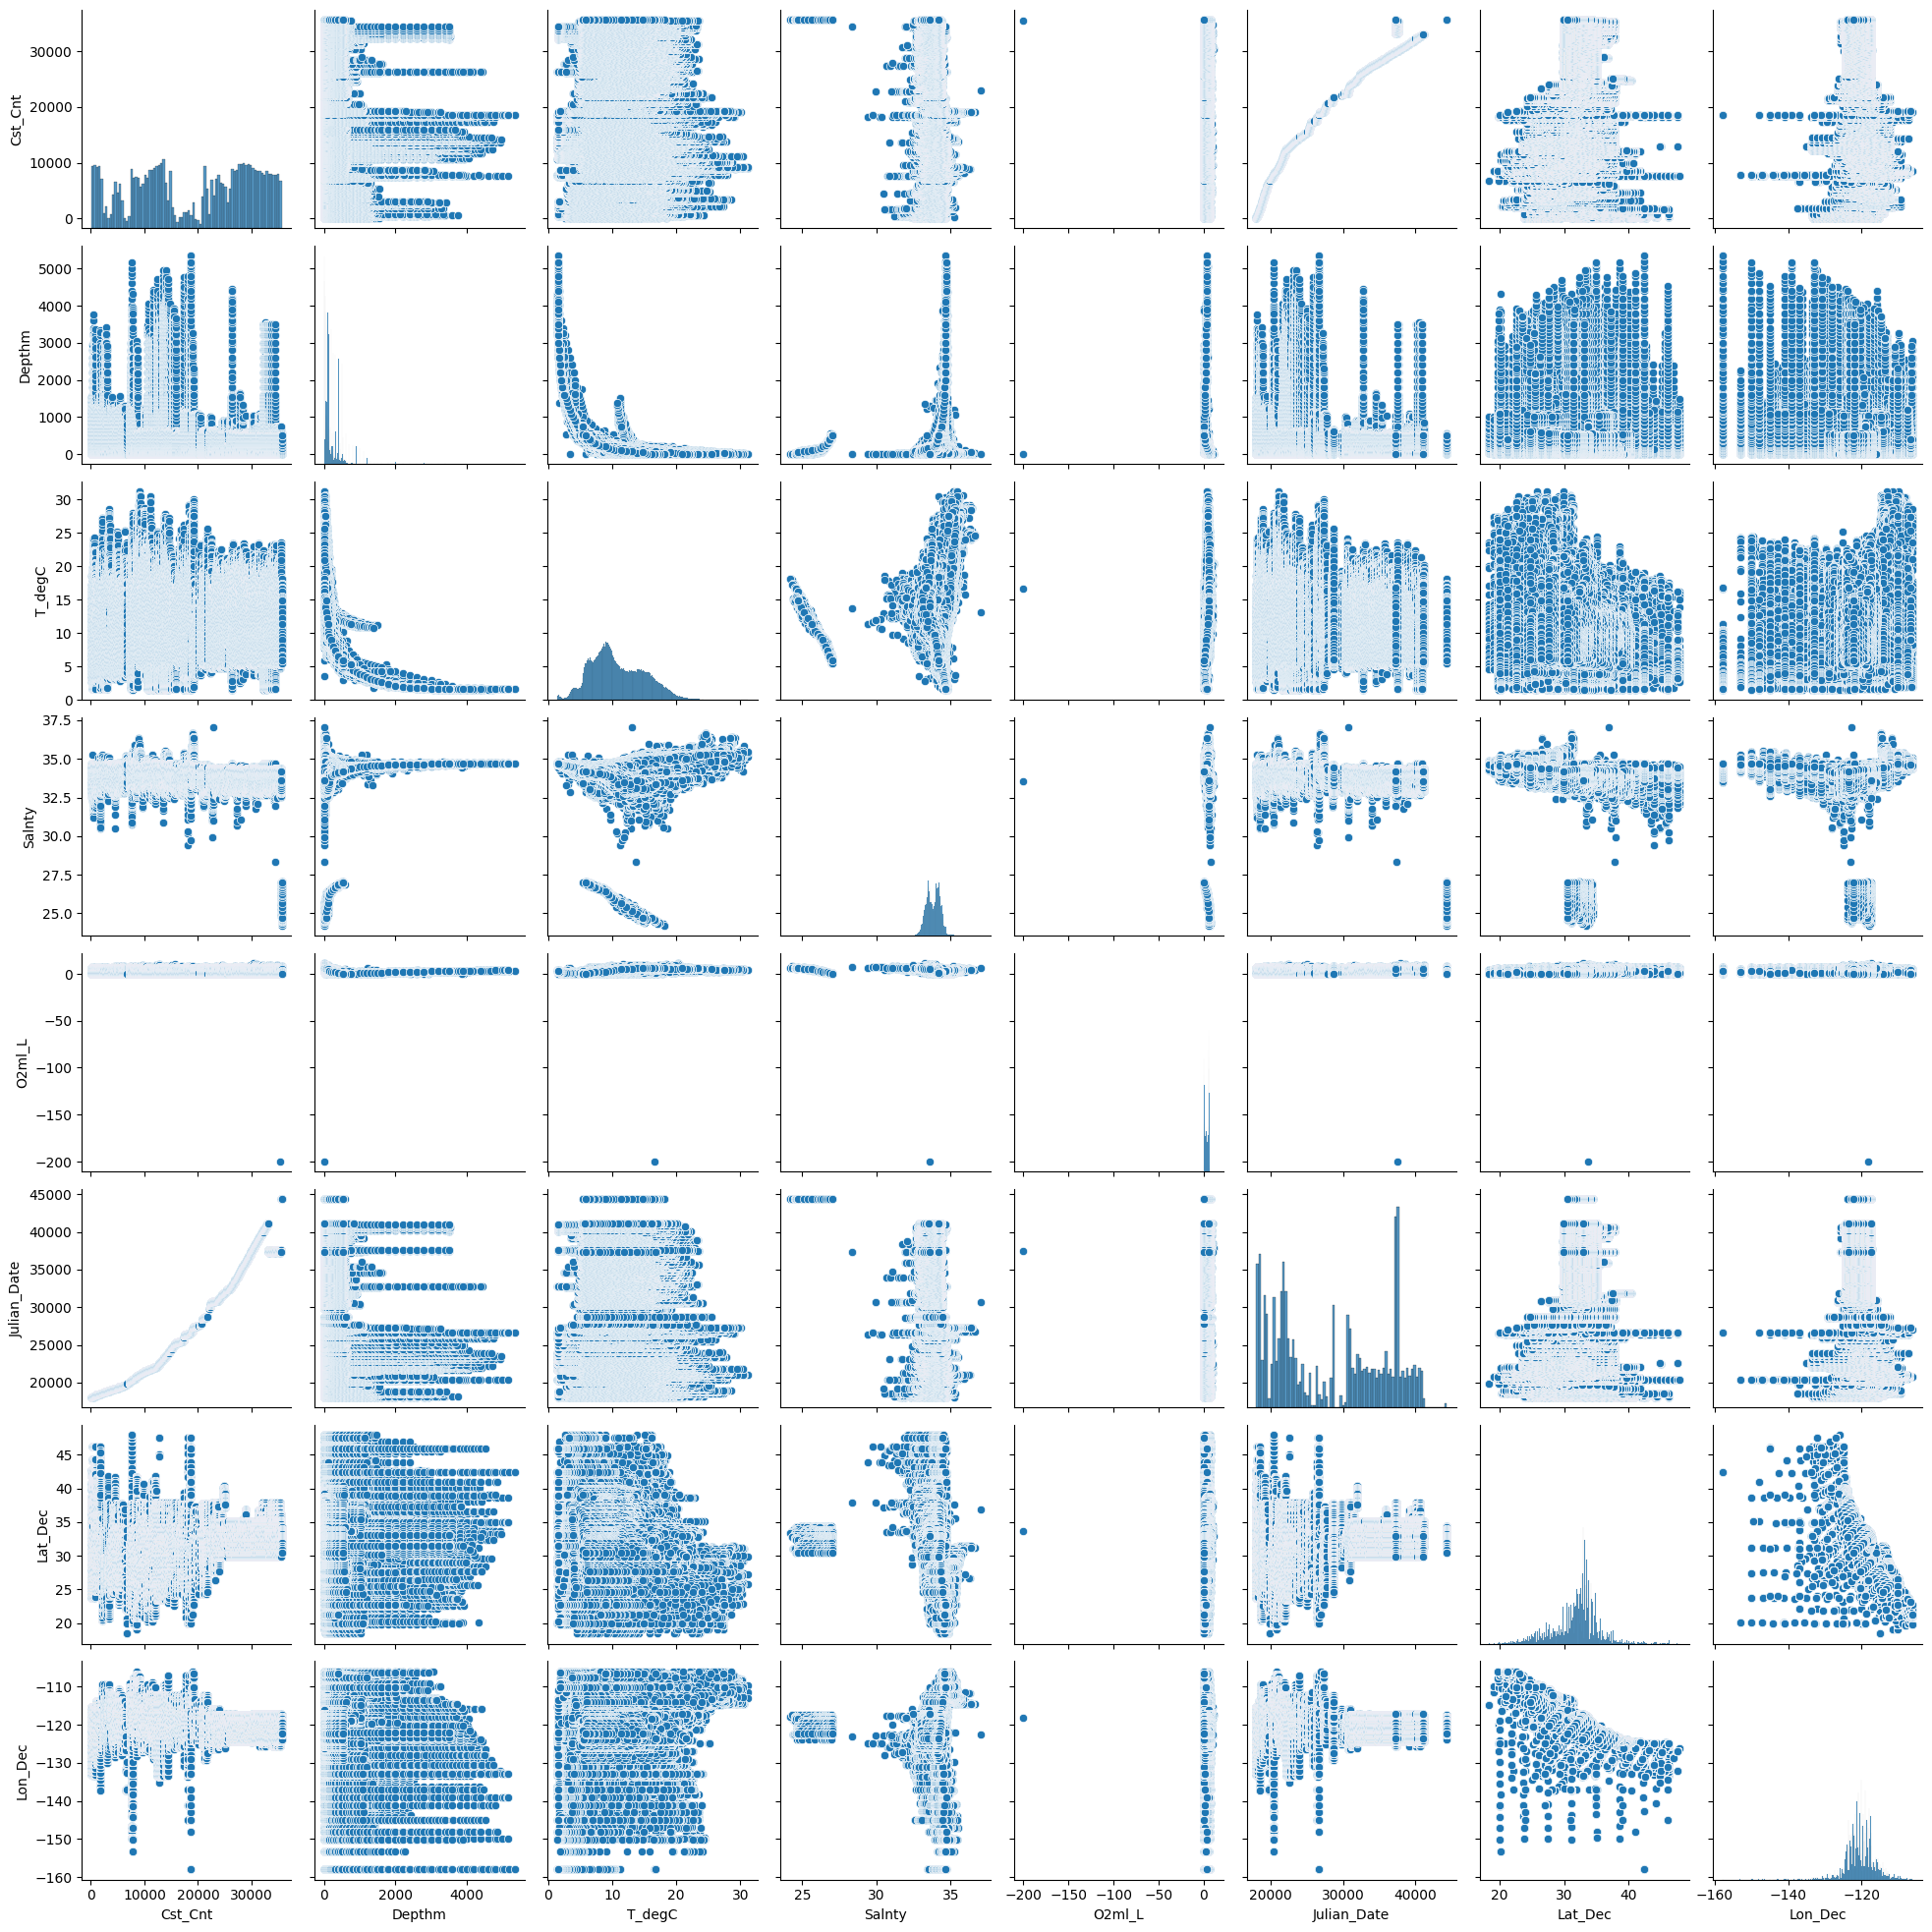

In [8]:
sns.pairplot(df_merge)

Outliers verwijderen

In [9]:
# De zuurstofconcentratie heeft een outlier, die een foute meting lijkt -> vervangen door mediaanwaarde.
# De rijen met outliers in Salnty column (onder 22.5) verwijderen.
O_mediaan = df_merge['O2ml_L'].median()
df_merge['O2ml_L'] = df_merge['O2ml_L'].apply(lambda x: O_mediaan if x < -100 else x)
df_merge = df_merge[bottle['Salnty'] > 22.5]


C:\Users\f_voe\AppData\Local\Temp\ipykernel_1792\1458655806.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_merge = df_merge[bottle['Salnty'] > 22.5]


Er zijn twee clusters in de data (één groep ligt helemaal los van de rest) van de zoutconcentratie (Salnty). Dit data-profiel kan niet goed worden gemodelleerd met lineaire regressie. Dit heeft mogelijk te maken met de plaats of tijd.
Ik probeer te achterhalen waardoor het verschil komt. (Salnty < 28)
 

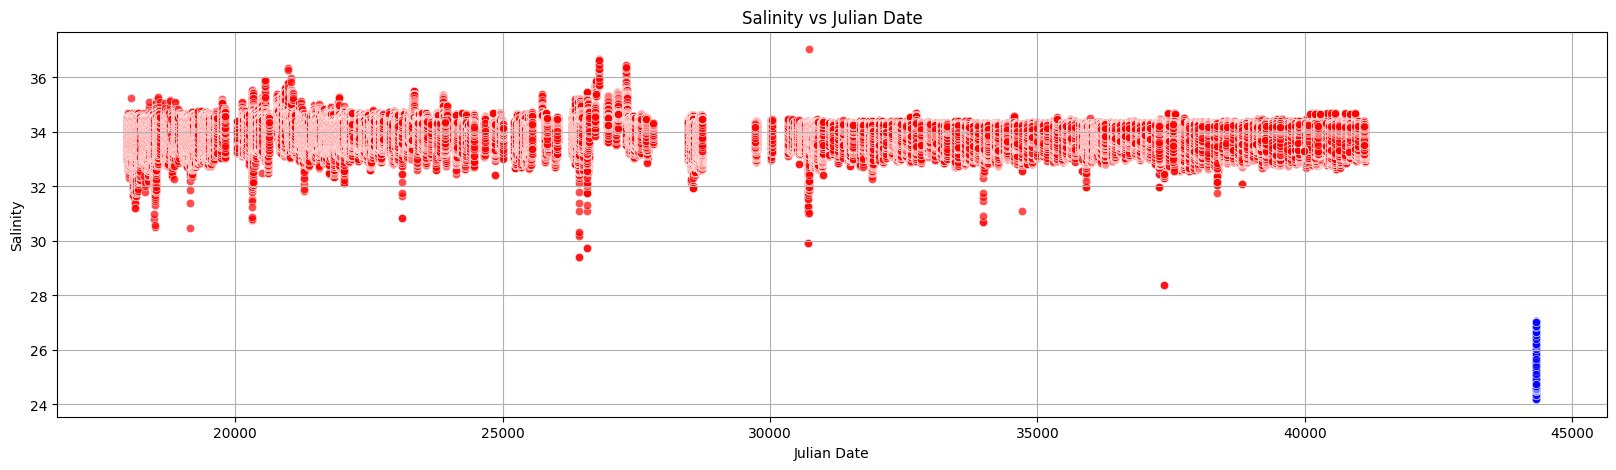

In [11]:
fig, ax = plt.subplots(figsize=(20,5))
bottle_sal_low = df_merge[df_merge['Salnty'] < 28].copy()
bottle_sal_high= df_merge[df_merge['Salnty']>=28].copy()
plot1=sns.scatterplot(data=bottle_sal_low,x='Julian_Date',y='Salnty', c= 'blue', alpha=0.7)
plot1=sns.scatterplot(data=bottle_sal_high,x='Julian_Date',y='Salnty', c= 'red', alpha=0.7)
ax.set(xlabel='Julian Date',ylabel='Salinity',title='Salinity vs Julian Date')
ax.grid()





De metingen met de lage zoutconcentratie lijken een fout in de metingen die rond Julian Date 44000 zijn uitgevoerd. 
Kijken of die rijen ook in andere features afwijken. 



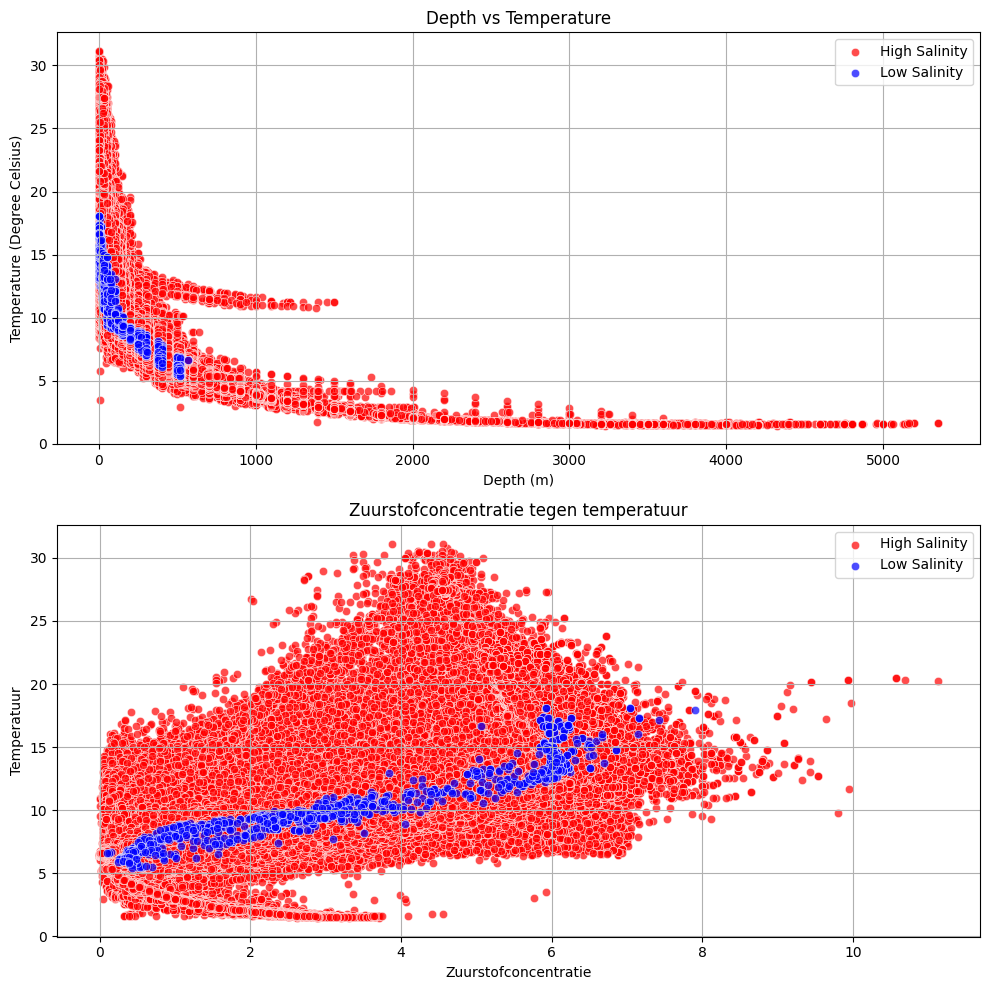

In [12]:
fig, ax = plt.subplots(2,1, figsize=(10,10))
plot1=sns.scatterplot(data=bottle_sal_high,x='Depthm', y='T_degC', c= 'red', alpha=0.7, label='High Salinity', ax = ax[0])
plot1=sns.scatterplot(data=bottle_sal_low,x='Depthm', y='T_degC', c= 'blue', alpha=0.7, label='Low Salinity', ax = ax[0])
ax[0].set(xlabel='Depth (m)',ylabel='Temperature (Degree Celsius)',title='Depth vs Temperature')
ax[0].grid()
ax[0].legend()
plot2=sns.scatterplot(data=bottle_sal_high,x='O2ml_L', y='T_degC', c= 'red', alpha=0.7, label='High Salinity', ax = ax[1])
plot2=sns.scatterplot(data=bottle_sal_low,x='O2ml_L', y='T_degC', c= 'blue', alpha=0.7, label='Low Salinity', ax = ax[1])
ax[1].set(xlabel='Zuurstofconcentratie',ylabel='Temperatuur',title='Zuurstofconcentratie tegen temperatuur')
ax[1].grid()
ax[1].legend()
plt.tight_layout() 
plt.show()




De andere metingen op die datum wijken niet af van de rest van de metingen. Er was misschien alleen iets 
mis met de zoutmeting. Omdat de zoutconcentratie een belangrijke parameter is en geen verstoringen te krijgen, haal ik die metingen eruit. Ik ga dus verder met bottle_sal_high (Salnty >= 28). 

Er is een rare curve in de temperatuur vs diepte plot. Laten we proberen te achterhalen wat daar aan de hand is. 
Hier is de temperatuur boven 10 graden en de diepte boven 600 meter.

In [13]:
curve_search = bottle_sal_high[(bottle_sal_high['T_degC'] > 10) & (bottle_sal_high['Depthm'] > 600)].copy()
cols = curve_search.columns
for col in cols : 
    print(curve_search[col].value_counts())

Cst_Cnt
19170    17
19068    16
13774     9
8937      9
19061     9
19156     8
8936      7
19146     6
8726      5
8725      5
8650      4
19171     4
9152      4
8938      3
19057     3
9151      2
19155     2
8209      1
8208      1
9148      1
Name: count, dtype: int64
Depthm
700     17
800     13
900     10
1000     6
1100     5
        ..
1332     1
1382     1
655      1
704      1
754      1
Name: count, Length: 67, dtype: int64
T_degC
11.33    5
11.22    5
11.45    4
11.16    3
11.20    3
        ..
10.88    1
10.83    1
10.80    1
10.74    1
11.46    1
Name: count, Length: 76, dtype: int64
Salnty
34.800    4
34.803    4
34.880    3
34.940    3
34.814    3
         ..
34.777    1
34.771    1
34.762    1
34.828    1
34.808    1
Name: count, Length: 77, dtype: int64
O2ml_L
1.00    5
1.33    4
1.46    4
1.53    4
0.83    4
       ..
0.74    1
0.71    1
0.67    1
0.66    1
0.87    1
Name: count, Length: 69, dtype: int64
Cruise_ID
1974-10-02-C-31AX    37
1974-04-08-C-31AX    28
1957

In [14]:
#Deze data zijn afkomstig van slechts enkele Cruise_ID's. Nogmaals het bovenstaande, maar nu alleen 
# voor Cruise_ID
curve_search['Cruise_ID'].value_counts()

Cruise_ID
1974-10-02-C-31AX    37
1974-04-08-C-31AX    28
1957-06-07-C-31ST    19
1957-04-07-C-31BD    10
1963-11-13-C-31AX     9
1957-08-17-C-31ST     7
1957-02-09-C-31SB     4
1956-04-08-C-31BD     2
Name: count, dtype: int64

In [15]:
cruise_location = bottle_sal_high.groupby(['Cruise_ID', 'Lat_Dec', 'Lon_Dec'], as_index=False).agg({
    'Depthm': 'mean',
    'T_degC': 'mean',
    'Salnty': 'mean',
    'O2ml_L': 'mean'
})

curve_location = curve_search.groupby(['Cruise_ID', 'Lat_Dec', 'Lon_Dec'], as_index=False).agg({
    'Depthm': 'mean',
    'T_degC': 'mean',
    'Salnty': 'mean',
    'O2ml_L': 'mean'
})


In [ ]:
#Kijken waar deze Cruises zich bevonden.

fig = px.scatter_mapbox(cruise_location, lat="Lat_Dec", lon="Lon_Dec", 
                        color_discrete_sequence=["#FFA15A"], zoom=3, 
                        height=800,
                        width=800)
fig2 = px.scatter_mapbox(curve_location, lat="Lat_Dec", lon="Lon_Dec", 
                         color_discrete_sequence=["#AB63FA"], zoom=3, 
                        height=800,
                        width=800)

for trace in fig2.data:
    fig.add_trace(trace)

fig.update_layout(mapbox_style="open-street-map")
fig.show()


Al deze metingen zijn dicht bij elkaar gedaan. Eens zien hoe de diepte op die plek is.

In [17]:
cruise_location['Depth_log'] = np.log(cruise_location['Depthm']+1)

In [18]:
import plotly.express as px
fig = px.scatter_mapbox(cruise_location, lat="Lat_Dec", lon="Lon_Dec", 
                        hover_data=["T_degC"], color="Depth_log", zoom=3, 
                        height=800,
                        width=800)

# Update layout with Mapbox style
fig.update_layout(mapbox_style="open-street-map")

# Show the map
fig.show()

Het lijkt dat de vrij grote diepte zo dichtbij land en/of het eilandje de oorzaak zijn van de uitstekende piek in de diepte-temperatuur plot. Ik laat de data erin.

Boxplot maken

([0, 1, 2, 3],
 [Text(0, 0, 'Depthm'),
  Text(1, 0, 'T_degC'),
  Text(2, 0, 'Salnty'),
  Text(3, 0, 'O2ml_L')])

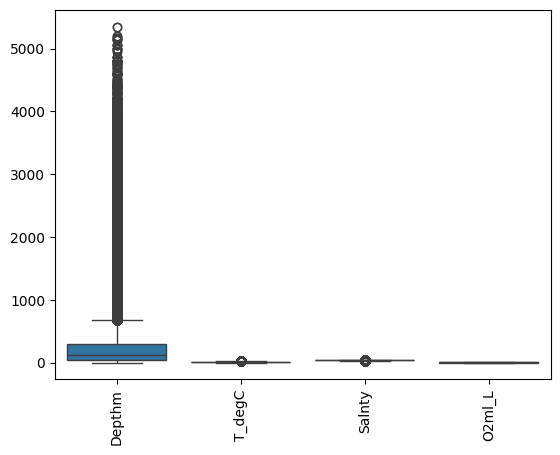

In [19]:
bottle_sal_high_boxplot = bottle_sal_high[['Depthm', 'T_degC', 'Salnty', 'O2ml_L']].copy()
sns.boxplot(data=bottle_sal_high_boxplot)
plt.xticks(rotation=90)

In [21]:
#Depth en T_degC hebben veel outliers aan de bovenkant: neem log van de waardes
bottle_sal_high.loc[:, 'Depth_log'] = np.log1p(bottle_sal_high['Depthm'])
bottle_sal_high.loc[:, 'T_log'] = np.log1p(bottle_sal_high['T_degC'])
bottle_sal_high= bottle_sal_high.drop(columns=['Depthm', 'T_degC'], axis=1)

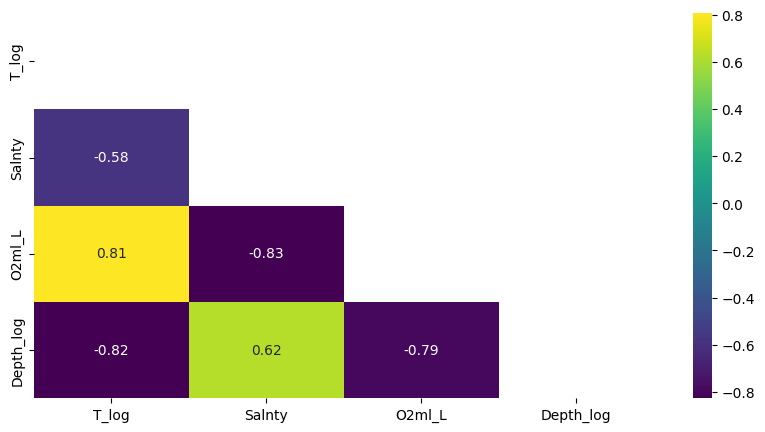

In [23]:
plt.figure(figsize=(10,5))
mask = np.triu(np.ones_like(bottle_sal_high_boxplot2.corr(numeric_only = True), dtype=bool))
sns.heatmap(bottle_sal_high_boxplot2.corr(numeric_only = True), cbar = True, annot = True, cmap="viridis", mask = mask);

# <div style="padding: 30px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#37644A;overflow:hidden;background-color:#37644A"><b>Lineaire regressie</b></div>



Split de data in een trainings-, validatie- en testset. De testset wordt gebruikt om het beste model op te testen.

In [34]:
### Split in training-, validatie- en testset

X= bottle_sal_high[['Salnty', 'O2ml_L', 'Depth_log']].copy()
y= bottle_sal_high['T_log'].copy()


X_temp, X_test,y_temp,y_test= train_test_split(X,y,test_size=0.1,random_state=0)
y_temp = y_temp.values.reshape(-1, 1)
y_test = y_test.values.reshape(-1, 1)

X_train, X_validate,y_train,y_validate= train_test_split(X_temp,y_temp,test_size=0.2,random_state=0)
X_train.shape,X_validate.shape, X_test.shape, y_train.shape, y_validate.shape, y_test.shape


((496821, 3), (124206, 3), (69004, 3), (496821, 1), (124206, 1), (69004, 1))

Model 1 : lineaire regressie

In [35]:
# lineaire regressie
lr = LinearRegression()
lr.fit(X_train,y_train)
y_pred = lr.predict(X_validate)

In [36]:
# fout berekenen - root mean squared error
mse=mean_squared_error(y_validate, y_pred)
RMSE_lr=mse**(1/2.0)

print(f"RMSE lineare regressie: {RMSE_lr:.4f}")

RMSE lineare regressie: 0.1838


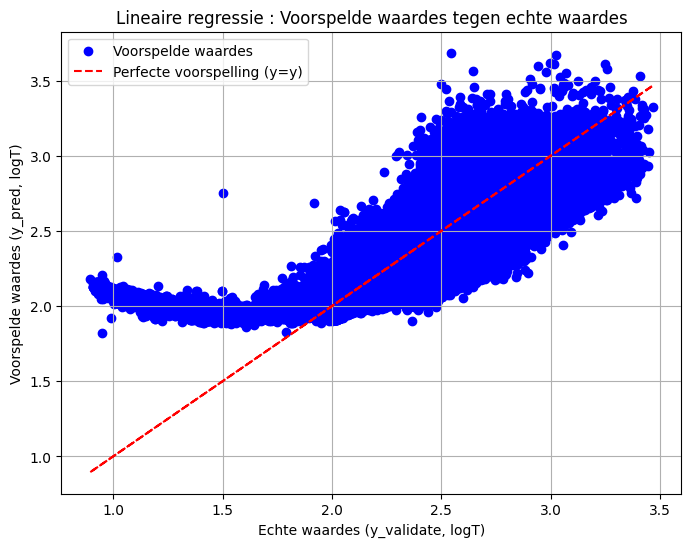

In [37]:
# Het resultaat plotten
plt.figure(figsize=(8, 6))
plt.scatter(y_validate, y_pred, color='blue', label='Voorspelde waardes')
plt.plot(y_validate, y_validate, color='red', linestyle='--', label='Perfecte voorspelling (y=y)')
plt.xlabel("Echte waardes (y_validate, logT)")
plt.ylabel("Voorspelde waardes (y_pred, logT)")
plt.title("Lineaire regressie : Voorspelde waardes tegen echte waardes")
plt.legend()
plt.grid(True)
plt.show()


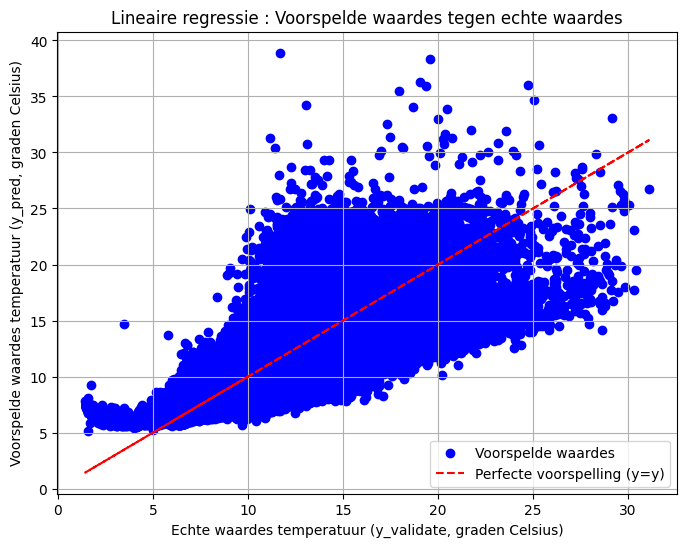

In [38]:
# Dezelfde plot, maar nu met de normale temperatuurwaardes
plt.figure(figsize=(8, 6))
plt.scatter(np.expm1(y_validate), np.expm1(y_pred), color='blue', label='Voorspelde waardes')
plt.plot(np.expm1(y_validate), np.expm1(y_validate), color='red', linestyle='--', label='Perfecte voorspelling (y=y)')
plt.xlabel("Echte waardes temperatuur (y_validate, graden Celsius)")
plt.ylabel("Voorspelde waardes temperatuur (y_pred, graden Celsius)")
plt.title("Lineaire regressie : Voorspelde waardes tegen echte waardes")
plt.legend()
plt.grid(True)
plt.show()




model 2: lineaire regressie met ridge regularisatie

In [39]:
ridge_cv = RidgeCV(alphas=[0.1, 1.0, 10.0, 100.0])
ridge_cv.fit(X_train, y_train)

# Get the best alpha
best_alpha = ridge_cv.alpha_
print(f"Best alpha: {best_alpha}")

# Predict and evaluate with best model
y_pred_ridge = ridge_cv.predict(X_validate)
mse_ridge = mean_squared_error(y_validate, y_pred_ridge)
r2_ridge = r2_score(y_validate, y_pred_ridge)
RMSE_ridge=mse_ridge**(1/2.0)
print(f"MSE with best alpha: {mse_ridge:.4f}")
print(f"R² Score with best alpha: {r2_ridge:.4f}")
print(f"RMSE with best alpha: {RMSE_ridge:.4f}")

Best alpha: 1.0
MSE with best alpha: 0.0338
R² Score with best alpha: 0.7571
RMSE with best alpha: 0.1838


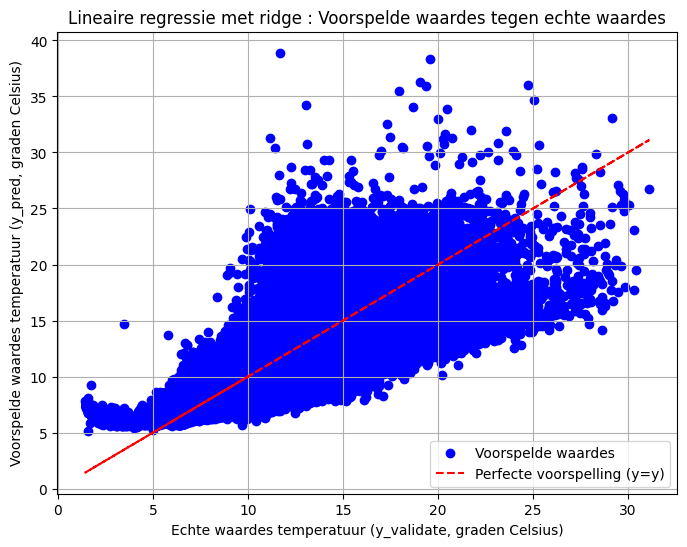

In [40]:
# Dezelfde plot, maar nu met de normale temperatuurwaardes
plt.figure(figsize=(8, 6))
plt.scatter(np.expm1(y_validate), np.expm1(y_pred_ridge), color='blue', label='Voorspelde waardes')
plt.plot(np.expm1(y_validate), np.expm1(y_validate), color='red', linestyle='--', label='Perfecte voorspelling (y=y)')
plt.xlabel("Echte waardes temperatuur (y_validate, graden Celsius)")
plt.ylabel("Voorspelde waardes temperatuur (y_pred, graden Celsius)")
plt.title("Lineaire regressie met ridge : Voorspelde waardes tegen echte waardes")
plt.legend()
plt.grid(True)
plt.show()




model 3 : lineaire regressie met lasso regularisatie

In [41]:
lasso_cv = LassoCV(alphas=[0.1, 1.0, 10.0, 100.0])
lasso_cv.fit(X_train, y_train)

# Get the best alpha
best_alpha = lasso_cv.alpha_
print(f"Best alpha: {best_alpha}")

# Predict and evaluate with best model
y_pred_lasso = lasso_cv.predict(X_validate)
mse_lasso = mean_squared_error(y_validate, y_pred_lasso)
r2_lasso = r2_score(y_validate, y_pred_lasso)
RMSE_lasso=mse_lasso**(1/2.0)
print(f"MSE with best alpha: {mse_lasso:.4f}")
print(f"R² Score with best alpha: {r2_lasso:.4f}")
print(f"RMSE with best alpha: {RMSE_lasso:.4f}")


c:\Users\f_voe\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1664: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



Best alpha: 0.1
MSE with best alpha: 0.0402
R² Score with best alpha: 0.7111
RMSE with best alpha: 0.2004


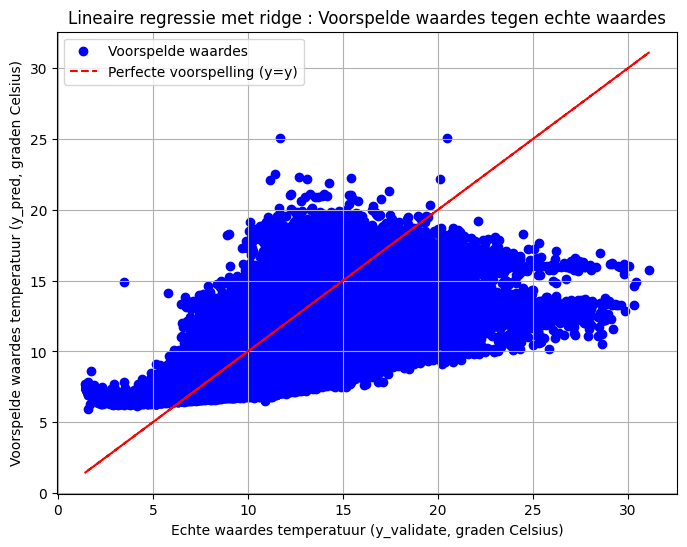

In [42]:
# Dezelfde plot, maar nu met de normale temperatuurwaardes
plt.figure(figsize=(8, 6))
plt.scatter(np.expm1(y_validate), np.expm1(y_pred_lasso), color='blue', label='Voorspelde waardes')
plt.plot(np.expm1(y_validate), np.expm1(y_validate), color='red', linestyle='--', label='Perfecte voorspelling (y=y)')
plt.xlabel("Echte waardes temperatuur (y_validate, graden Celsius)")
plt.ylabel("Voorspelde waardes temperatuur (y_pred, graden Celsius)")
plt.title("Lineaire regressie met ridge : Voorspelde waardes tegen echte waardes")
plt.legend()
plt.grid(True)
plt.show()




model 4 : lineare regressie met scaling vooraf

In [43]:
# Scaling en Lineaire regressie
std_scaler = StandardScaler()
lr = LinearRegression()
polynomial_regression = make_pipeline(std_scaler, lr)
polynomial_regression.fit(X_train, y_train)
y_pred = polynomial_regression.predict(X_validate)
mse = mean_squared_error(y_validate, y_pred)
RMSE_LR_SC = mse**(1/2.0)

print(f"RMS_LR_SC : {RMSE_LR_SC:.4f}")

RMS_LR_SC : 0.1838


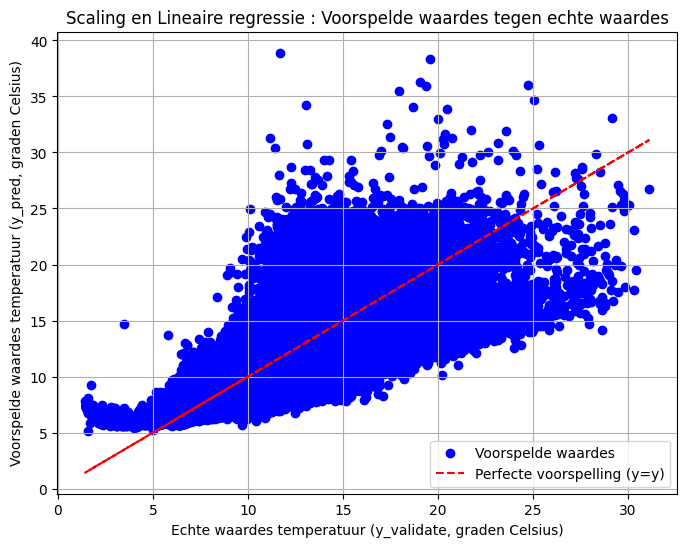

In [44]:
# Resultaat Scaling en Lineaire regressie plotten
plt.figure(figsize=(8, 6))
plt.scatter(np.expm1(y_validate), np.expm1(y_pred), color='blue', label='Voorspelde waardes')
plt.plot(np.expm1(y_validate), np.expm1(y_validate), color='red', linestyle='--', label='Perfecte voorspelling (y=y)')
plt.xlabel("Echte waardes temperatuur (y_validate, graden Celsius)")
plt.ylabel("Voorspelde waardes temperatuur (y_pred, graden Celsius)")
plt.title("Scaling en Lineaire regressie : Voorspelde waardes tegen echte waardes")
plt.legend()
plt.grid(True)
plt.show()




In [45]:
# Polynomial features, Scaling en Lineaire regressie

poly_features = PolynomialFeatures(degree=2, include_bias=False) 
std_scaler = StandardScaler()
lr = LinearRegression()
polynomial_regression = make_pipeline(poly_features, std_scaler, lr)
polynomial_regression.fit(X_train, y_train)
y_pred = polynomial_regression.predict(X_validate)
mse = mean_squared_error(y_validate, y_pred)
RMSE_PF_LR_SC = mse**(1/2.0)

print(f"RMS_PF_LR_SC : {RMSE_PF_LR_SC:.4f}")

RMS_PF_LR_SC : 0.1098


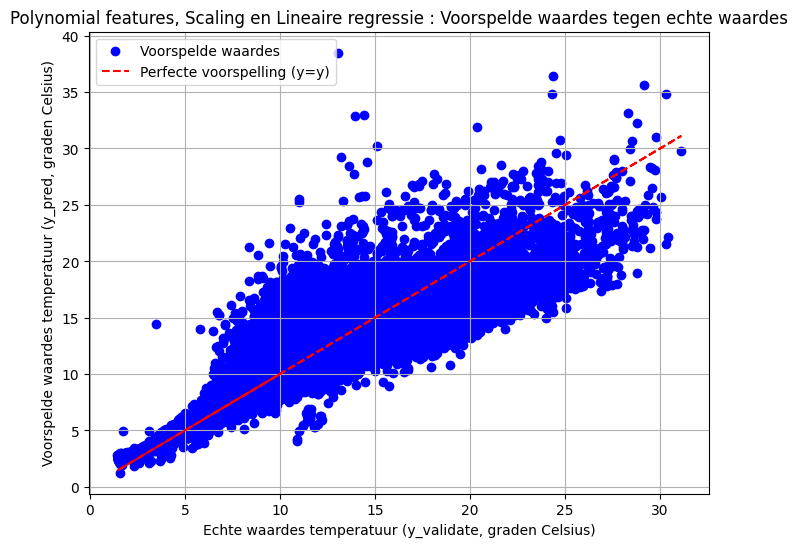

In [46]:
# Resultaat Polynomial features, Scaling en Lineaire regressie plotten
plt.figure(figsize=(8, 6))
plt.scatter(np.expm1(y_validate), np.expm1(y_pred), color='blue', label='Voorspelde waardes')
plt.plot(np.expm1(y_validate), np.expm1(y_validate), color='red', linestyle='--', label='Perfecte voorspelling (y=y)')
plt.xlabel("Echte waardes temperatuur (y_validate, graden Celsius)")
plt.ylabel("Voorspelde waardes temperatuur (y_pred, graden Celsius)")
plt.title("Polynomial features, Scaling en Lineaire regressie : Voorspelde waardes tegen echte waardes")
plt.legend()
plt.grid(True)
plt.show()




# <div style="padding: 30px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#37644A;overflow:hidden;background-color:#37644A"><b>Conclusie</b></div>



De RMSE-waardes voor de verschillende modellen :

In [47]:
print(f"Model 1 RMSE lineare regressie: {RMSE_lr:.4f}")
print(f"Model 2 RMSE lineare regressie met ridge regularisatie: {RMSE_ridge:.4f}")
print(f"Model 3 RMSE lineare regressie met lasso regularisatie: {RMSE_lasso:.4f}")
print(f"Model 4 RMSE lineaire regressie met scaling vooraf : {RMSE_LR_SC:.4f}")
print(f"Model 5 RMSE lineaire regressie met scaling en polynomial features: {RMSE_PF_LR_SC:.4f}")



Model 1 RMSE lineare regressie: 0.1838
Model 2 RMSE lineare regressie met ridge regularisatie: 0.1838
Model 3 RMSE lineare regressie met lasso regularisatie: 0.2004
Model 4 RMSE lineaire regressie met scaling vooraf : 0.1838
Model 5 RMSE lineaire regressie met scaling en polynomial features: 0.1098


Model 5, lineaire regressie met scaling en polynomial features, geeft de laagste RMSE en ook uit de plot blijkt dat dit het beste model is. 
Dit model gebruik ik om de test-data te voorspellen.

In [48]:
y_pred_test = polynomial_regression.predict(X_test)
mse = mean_squared_error(y_test, y_pred_test)
RMSE_test = mse**(1/2.0)
print(f"RMSE_test : {RMSE_test:.4f}")

RMSE_test : 0.1096


Het model werkt bijna even goed op de test set. Conclusie: het model voorspelt redelijk goed en is generaliseerbaar naar andere data.